In [1]:
!pip install -q statsmodels dtreeviz ta

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
!apt-get update && apt-get install -yy graphviz

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]      
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]    
Ign:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:5 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]    
Get:6 http://archive.ubuntu.com/ubuntu bionic-updates/restricted amd64 Packages [426 kB]
Get:7 http://archive.ubuntu.com/ubuntu bionic-updates/multiverse amd64 Packages [31.6 kB]
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 Packages [2546 kB]
Get:9 http://security.ubuntu.com/ubuntu bionic-security/restricted amd64 Packages [396 kB]
Ign:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 Packages [2181 kB]
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/

debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package libxau6:amd64.
(Reading database ... 17013 files and directories currently installed.)
Preparing to unpack .../00-libxau6_1%3a1.0.8-1ubuntu1_amd64.deb ...
Unpacking libxau6:amd64 (1:1.0.8-1ubuntu1) ...
Selecting previously unselected package libbsd0:amd64.
Preparing to unpack .../01-libbsd0_0.8.7-1ubuntu0.1_amd64.deb ...
Unpacking libbsd0:amd64 (0.8.7-1ubuntu0.1) ...
Selecting previously unselected package libxdmcp6:amd64.
Preparing to unpack .../02-libxdmcp6_1%3a1.1.2-3_amd64.deb ...
Unpacking libxdmcp6:amd64 (1:1.1.2-3) ...
Selecting previously unselected package libxcb1:amd64.
Preparing to unpack .../03-libxcb1_1.13-2~ubuntu18.04_amd64.deb ...
Unpacking libxcb1:amd64 (1.13-2~ubuntu18.04) ...
Selecting previously unselected package libx11-data.
Preparing to unpack .../04-libx11-data_2%3a1.6.4-3ubuntu0.3_all.deb ...
Unpacking libx11-data (2:1.6.4-3ubuntu0.3) ...
Selecting 

Setting up liblab-gamut1 (2.40.1-2) ...
Setting up libjbig0:amd64 (2.1-3.1build1) ...
Setting up fonts-dejavu-core (2.37-1) ...
Setting up libdatrie1:amd64 (0.2.10-7) ...
Setting up libtiff5:amd64 (4.0.9-5ubuntu0.4) ...
Setting up libbsd0:amd64 (0.8.7-1ubuntu0.1) ...
Setting up fonts-liberation (1:1.07.4-7~18.04.1) ...
Setting up ucf (3.0038) ...
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76.)
debconf: falling back to frontend: Readline
Setting up libgraphite2-3:amd64 (1.3.11-2) ...
Setting up libpixman-1-0:amd64 (0.34.0-2) ...
Setting up libltdl7:amd64 (2.4.6-2) ...
Setting up libann0 (1.1.2+doc-6) ...
Setting up libgts-bin (0.7.6+darcs121130-4) ...
Setting up libthai-data (0.1.27-2) ...
Setting up libxdmcp6:amd64 (1:1.1.2-3) ...
Setting up x11-common (1:7.7+19ubuntu7.1) ...
debconf: unable to initialize frontend: Dialog
debconf: (N

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
from joblib import dump, load

from ta import add_all_ta_features

from utils import check_data_gaps, preprocess_time_series
from feature_generation import Preprocess, create_features, get_feature_names

import warnings


jtplot.style()

In [2]:
data = pd.read_csv('data/btc_2021-01-01_2021-03-06_5m.csv', index_col=['date'], parse_dates=['date'])
data = (data
        .resample(rule='5min')
        .asfreq()
        .interpolate(method='time', limit=None))

warnings.filterwarnings("default")
data = add_all_ta_features(data, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

cols_to_scale = data.columns[(data.mean(axis=0) > 100) & (data.min(axis=0) > 0)]
for col in cols_to_scale:
    data[col] = np.log(data[col] + 1)
    
X_data = data.reset_index(drop=True)
np.seterr(invalid='raise')
warnings.filterwarnings("error")

X_features, Y, weights = create_features(data_raw=X_data,
                                         fs=1,
                                         segment_window=12*24,
                                         partitioning=True,
                                         window_length=12*24,
                                         label_length=12*4,
                                         stride= 12*4,
                                         subsample_factor= 1,
                                         binary_delta_labels=True,
                                         binary_delta_value='Close')

if np.where(np.isnan(X_features))[0].shape[0] > 0:
    print('NAN Values')
    
feature_names = get_feature_names(raw_names=X_data.columns)
X_features = pd.DataFrame(X_features, columns=feature_names)
print(f'Data shape: {X_features.shape}, labels shape: {Y.shape}, feature names: {len(feature_names)}')

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])
/usr/local/lib/python3.6/dist-packages/ta/trend.py:936: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_up = pd.Series(index=self._psar.index)
/usr/local/lib/python3.6/dist-packages/ta/trend.py:937: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_down = pd.Series(index=self._psar.index)


KeyboardInterrupt: 

In [25]:
weights = np.sum(weights) * weights / len(weights)

In [ ]:
def remove_correlated_features(input_data:pd.DataFrame, threshold: int=0.95) -> pd.DataFrame:
    frame = input_data.copy()
    corr_matrix = frame.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    frame.drop(to_drop, axis=1, inplace=True)
    return frame

X_features = remove_correlated_features(input_data=X_features, threshold=0.95)
feature_names = X_features.columns
# dump(feature_names.tolist(), 'saved_models/feature_list_v10.joblib')

In [23]:
# dump(cols_to_scale.tolist(), 'saved_models/column_scale_v2.joblib')

['saved_models/column_scale_v2.joblib']

In [ ]:
warnings.filterwarnings("default")

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectKBest, chi2, f_classif, VarianceThreshold, mutual_info_classif, SelectFpr, SelectFdr, SelectFwe,RFECV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer, QuantileTransformer, MinMaxScaler, label_binarize
from sklearn.model_selection import TimeSeriesSplit, StratifiedKFold, ParameterSampler
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, make_scorer, auc
from scipy.stats import spearmanr
import warnings


scorer = make_scorer(roc_auc_score, needs_proba=True, **{'multi_class':'ovo'})

model = Pipeline([
    ("threshold", VarianceThreshold()),
    ("scaler", StandardScaler()),
    ("feature_selection", SelectKBest(f_classif, k=20)),
#     ("classifier", RFECV(LogisticRegression(class_weight='balanced', solver='liblinear', penalty='l1', C=0.1), scoring=scorer)),
#     ("classifier", RFECV(DecisionTreeClassifier(class_weight='balanced', max_depth=3), scoring=scorer)),
#     ("classifier", LogisticRegressionCV(class_weight='balanced', solver='liblinear', penalty='l2', Cs=10, scoring=scorer))
    ("classifier", LogisticRegression(class_weight='balanced', solver='liblinear', penalty='l1', C=10))
])

# X = X_features.values[1:]
# y = y[1:] - y[:-1] + 1
X = X_features.values
y = Y

best_score = 0
best_params = []
best_preds = np.array([])
best_probs = np.array([])
model_lc = np.zeros(shape=(1, 2))

for k in range(5, 10):
    for c in [0.01, 0.1, 1, 10]:

        data_predictions = []
        data_probs = []
        data_labels = []
        data_weights = []
        splitter = TimeSeriesSplit()

        for i, (train_index, test_index) in enumerate(splitter.split(X)):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            w_train, w_test = weights[train_index], weights[test_index]

            model.set_params(**{"feature_selection__k": k,
                                "classifier__C": c})
            model.fit(X_train, y_train,
                      classifier__sample_weight=w_train)
            predictions = model.predict(X_test)
            data_predictions.extend(predictions)
            probs = model.predict_proba(X_test)#[:, 1]
            data_probs.extend(probs)
            data_labels.extend(y_test)
            data_weights.extend(w_test)

        data_predictions = np.array(data_predictions)
        data_probs = np.array(data_probs)
        data_labels = np.array(data_labels)
        data_weights = np.array(data_weights)

#         binned_labels = label_binarize(data_labels, classes=[0,1,2])
#         score = roc_auc_score(binned_labels, data_probs, sample_weight=data_weights, multi_class='ovo')
        score = roc_auc_score(data_labels, data_probs[:, 1], sample_weight=data_weights)

        if score > best_score:
            best_score = score
            best_params = [k, c]
            best_preds = data_predictions
            best_probs = data_probs
#             dump(model, 'saved_models/classification_model_BTC_v9.joblib')
            model_lc = np.vstack([model_lc, [k, score]])
            
# Loop end

data_predictions = best_preds
data_probs = best_probs
report = classification_report(data_labels, data_predictions, sample_weight=data_weights)
print(report)

# binned_labels = label_binarize(data_labels, classes=[0,1,2])

# n_classes = binned_labels.shape[1]
# data_probs = data_probs.reshape(-1, n_classes)
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(n_classes):
#     fpr[i], tpr[i], _ = roc_curve(binned_labels[:, i], data_probs[:, i], sample_weight=data_weights)
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # Plot of a ROC curve for a specific class
# for i in range(n_classes):
#     plt.figure()
#     plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
#     plt.plot([0, 1], [0, 1], 'k--')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver operating characteristic example')
#     plt.legend(loc="lower right")
#     plt.show()

roc = roc_auc_score(data_labels, data_probs[:, 1], sample_weight=data_weights)
fpr, tpr, _ = roc_curve(data_labels, data_probs[:, 1], sample_weight=data_weights)
fig, ax = plt.subplots(1,1, constrained_layout=True)
ax.plot(fpr, tpr)
ax.set_title(f'RoC Score: {roc}')
ax.set_xlabel('fpr')
ax.set_ylabel('tpr')
plt.show()

In [20]:
0.8*381

304.8

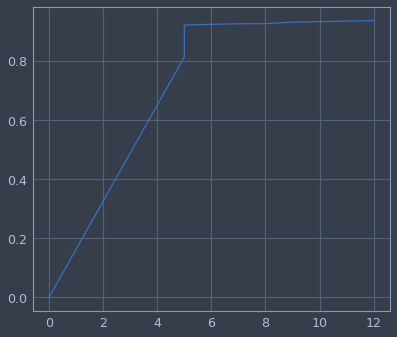

In [12]:
plt.plot(model_lc[:, 0], model_lc[:, 1])

(array([101.,  75.,  62.,  32.,  20.,  11.,   5.,   3.,   4.,   2.]),
 array([6.91648962e-05, 1.21522217e-02, 2.42352786e-02, 3.63183354e-02,
        4.84013922e-02, 6.04844490e-02, 7.25675059e-02, 8.46505627e-02,
        9.67336195e-02, 1.08816676e-01, 1.20899733e-01]),
 <BarContainer object of 10 artists>)

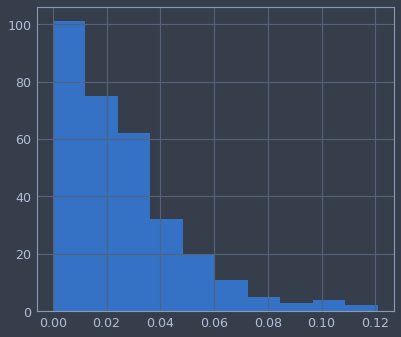

In [5]:
plt.hist(data_weights)

In [6]:
print(f'Num features: {best_params[0]}')
print(f'clf C: {best_params[1]}')

Num features: 9
clf C: 10


In [7]:
selected_features = X_features.columns
selected_features = selected_features[model[0].get_support()]
selected_data = model[1].transform(X_features[selected_features].values)
selected_data = pd.DataFrame(selected_data, columns=selected_features)
selected_features = selected_features[model[2].get_support()]
selected_data = selected_data[selected_features]

<AxesSubplot:title={'center':'Feature Importance'}>

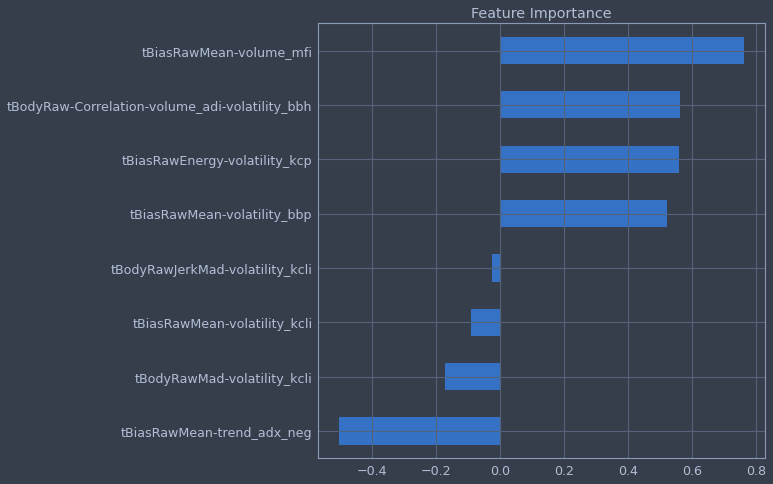

In [8]:
feature_importance = model[-1].coef_[0] * selected_data.std(axis=0)
feature_importance = feature_importance[feature_importance != 0.0]
feature_importance.sort_values(inplace=True)
feature_importance.plot(kind='barh', title='Feature Importance', figsize=(8,8))

In [ ]:
len(feature_importance)

In [328]:
from dtreeviz.trees import dtreeviz
import seaborn as sns
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
# sns.set()
# jtplot.style()

viz = dtreeviz(model[-1].estimator_, selected_data.loc[test_index], y[test_index],
               target_name="target",
               feature_names=selected_features,
               class_names=['fall', 'same', 'rise'],
#                colors={'axis_label': 'white',
#                        'title': 'white',
#                        'text': 'white',
#                        'node_label': 'white',
#                        'tick_label': 'white',
#                        'leaf_label': 'white',
#                        'split_line': 'white',
#                        'wedge': 'white',
#                        'text_wedge': 'white',
#                        'legend_title': 'white'}
              )

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2], y=[1 0 1 1 1 1 2 1 0 1 1 2 0 2 1 1 1 0 1 1 2 0 1 2 0 1 1 1 1 2 1 0 2 1 0 2 0
 1 1 1 2 0 1 2 1 0 2 1 1 1 1 0 2 0 1 1 2 1 1 1 0 1 2 0 1 1 1 1 1 2 0 2 1 1
 0 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


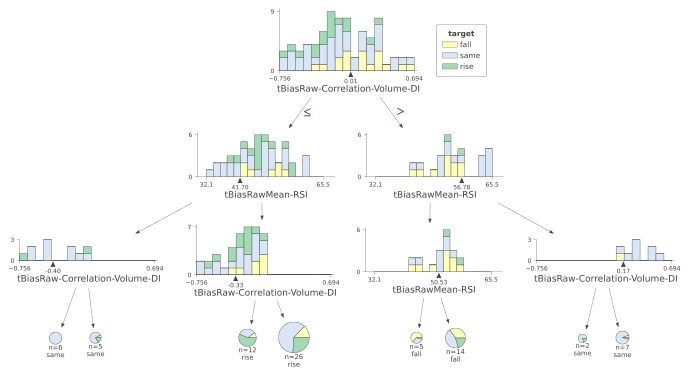

In [329]:
from IPython.display import display

display(viz)

In [299]:
viz.save('test.svg')

In [35]:
print(f'Model bias: {np.mean(np.argmax(data_probs, axis=1)) - np.mean(data_labels)}')

Model bias: -0.041269841269841234


In [40]:
#dump(model, 'saved_models/classification_model_BTC_v8.joblib')

['saved_models/classification_model_BTC_v8.joblib']

In [9]:
import functools
import operator
import datetime

def avg_datetime(series):
    dt_min = series.min().values
    deltas = [x-dt_min for x in series.values.astype('datetime64[ns]')]
    return dt_min + functools.reduce(operator.add, deltas) / len(deltas)

preprocessor = Preprocess(fs=1, seg_window=12*24)
_, dates, _ = preprocessor.partition_time_series(signal=pd.DataFrame(data.index),
                                           window_length=12*24,
                                           label_length=12*4,
                                           stride=12*4,
                                           subsample_factor= 1,
                                           binary_delta_labels= False,
                                           binary_delta_value= 'Close')
plot_ticks = np.array([avg_datetime(i) for i in dates]).flatten()[:-1]

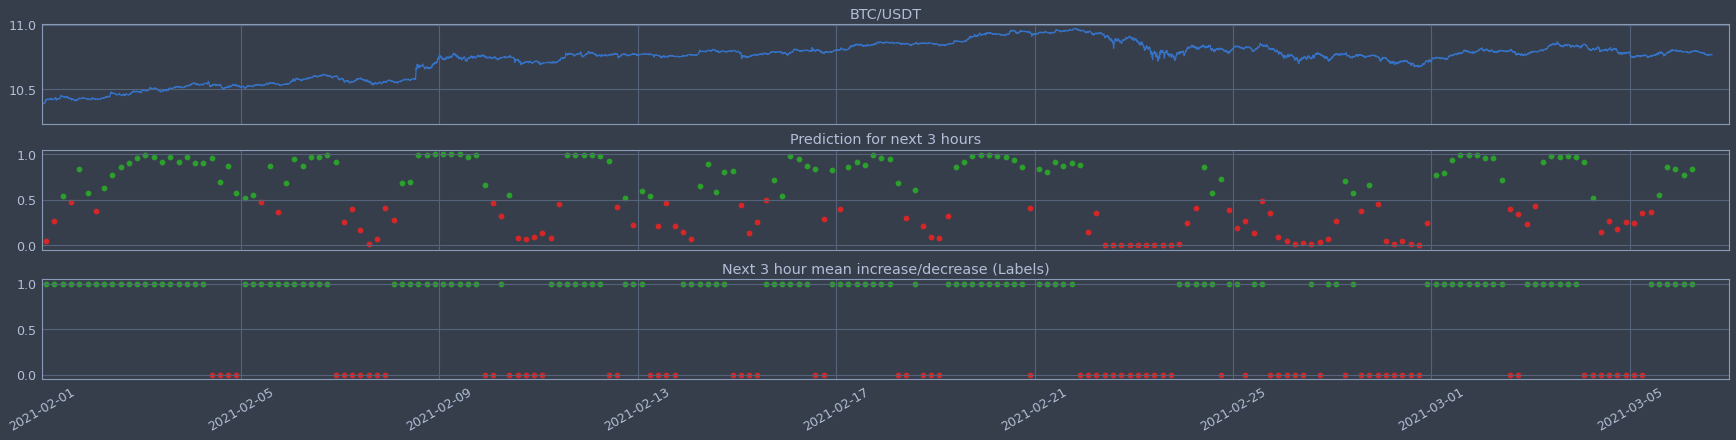

In [10]:
fig, ax = plt.subplots(3, 1, figsize=(24,6), constrained_layout=True, sharex=True)
ax[0].plot(data['Close'])
ax[0].set_title('BTC/USDT')
ax[1].scatter(plot_ticks[len(plot_ticks)-len(data_probs):][data_probs[:, 1] > 0.5], data_probs[data_probs[:, 1] > 0.5][:, 1], c='tab:green')
ax[1].scatter(plot_ticks[len(plot_ticks)-len(data_probs):][data_probs[:, 1] < 0.5], data_probs[data_probs[:, 1] < 0.5][:, 1], c='tab:red')
ax[1].scatter(plot_ticks[len(plot_ticks)-len(data_probs):][data_probs[:, 1] == 0.5], data_probs[data_probs[:, 1] == 0.5][:, 1], c='tab:grey')
ax[1].set_title('Prediction for next 3 hours')
ax[2].scatter(plot_ticks[len(plot_ticks)-len(data_labels):][data_labels > 0.5], data_labels[data_labels > 0.5], c='tab:green')
ax[2].scatter(plot_ticks[len(plot_ticks)-len(data_labels):][data_labels < 0.5], data_labels[data_labels < 0.5], c='tab:red')
ax[2].set_title('Next 3 hour mean increase/decrease (Labels)')
plt.gca().xaxis.set_tick_params(rotation = 30)
plt.gca().set_xbound('2021-02-01', '2021-03-07')
plt.show()

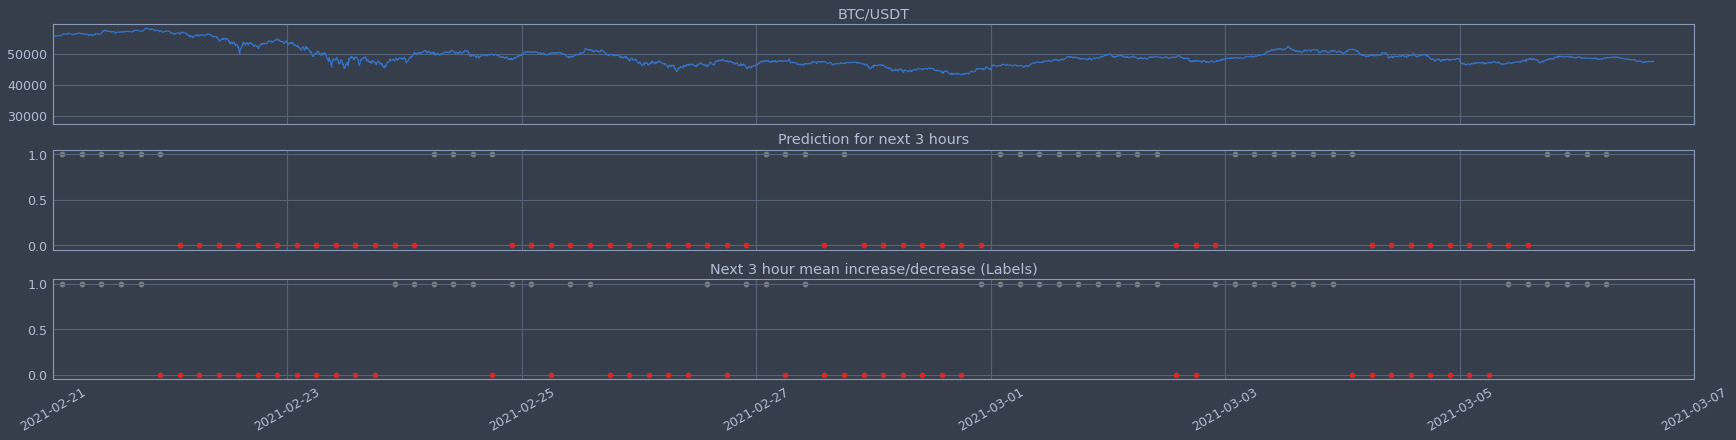

In [14]:
jtplot.style()
data_probs_class = np.argmax(data_probs, axis=1)
fig, ax = plt.subplots(3, 1, figsize=(24,6), constrained_layout=True, sharex=True)
ax[0].plot(np.exp(data['Close'])-1)
ax[0].set_title('BTC/USDT')
ax[1].scatter(plot_ticks[len(plot_ticks)-len(data_probs_class):][data_probs_class == 2], data_probs_class[data_probs_class == 2], c='tab:green')
ax[1].scatter(plot_ticks[len(plot_ticks)-len(data_probs_class):][data_probs_class == 0], data_probs_class[data_probs_class == 0], c='tab:red')
ax[1].scatter(plot_ticks[len(plot_ticks)-len(data_probs_class):][data_probs_class == 1], data_probs_class[data_probs_class == 1], c='tab:grey')
ax[1].set_title('Prediction for next 3 hours')
ax[2].scatter(plot_ticks[len(plot_ticks)-len(data_labels):][data_labels == 2], data_labels[data_labels == 2], c='tab:green')
ax[2].scatter(plot_ticks[len(plot_ticks)-len(data_labels):][data_labels == 0], data_labels[data_labels == 0], c='tab:red')
ax[2].scatter(plot_ticks[len(plot_ticks)-len(data_labels):][data_labels == 1], data_labels[data_labels == 1], c='tab:gray')
ax[2].set_title('Next 3 hour mean increase/decrease (Labels)')
plt.gca().xaxis.set_tick_params(rotation = 30)
plt.gca().set_xbound('2021-02-21', '2021-03-07')
plt.show()

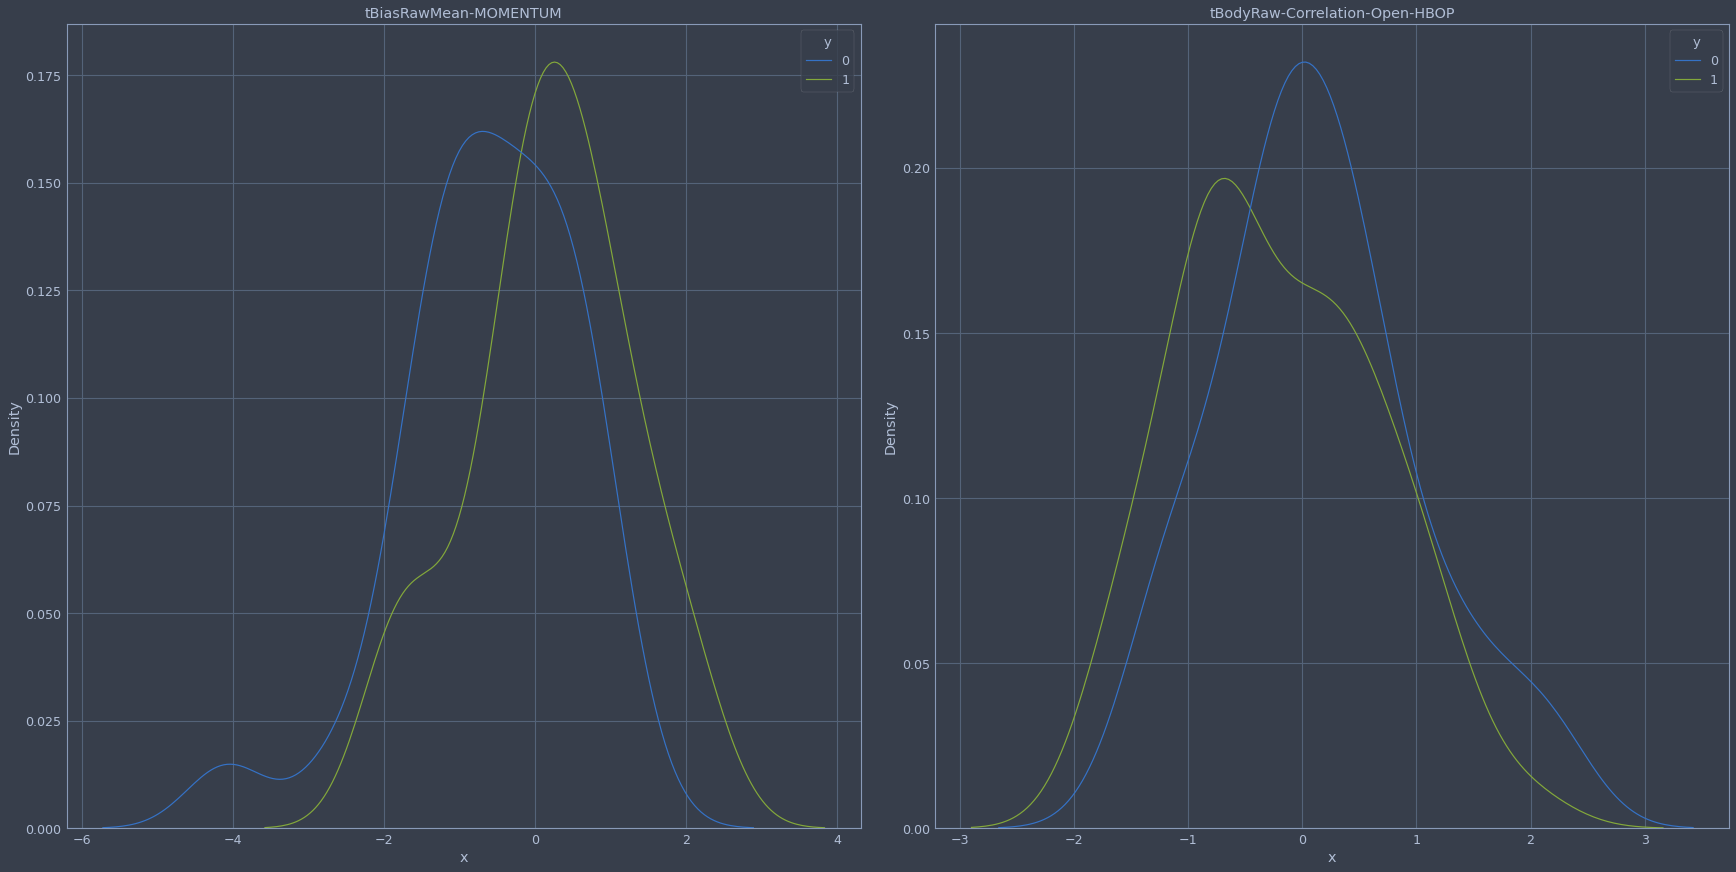

In [66]:
from seaborn import kdeplot

num_rows = int(np.floor(np.sqrt(len(feature_importance.index.tolist()))+0.5))
num_cols = int(np.ceil(np.sqrt(len(feature_importance.index.tolist()))))

fig, ax = plt.subplots(num_rows, num_cols, figsize=(24,12), constrained_layout=True)
ax = np.ravel(ax)
for i, c_name in enumerate(feature_importance.index.tolist()[::-1]):

    x_plot = selected_data[c_name].values[len(plot_ticks)-len(data_labels)+1:]
    y_plot = data_labels

    xy_plot = pd.DataFrame({
        'x': x_plot,
        'y': y_plot
    })
    kdeplot(data=xy_plot, x='x', ax=ax[i], hue='y')
    ax[i].set_title(c_name)
plt.show()